/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_8381/2575266922.py:8: DtypeWarning: Columns (31,38,41,44,46,53,65,68,74,85,95,111,113,114,117,119,120,122,123,125,126,127,129,132,135,138,141,144,147,150,153,156,159,162,165,168,171,174,177,180,183,186,189,192,195,198,201,204,207,210,213,216,219,222,225,228,231,234,237,240,243,246,249,252,255,258,261,264,267,270,273,276,279,282,285,288,291,294,297,300,303,306,309,312) have mixed types. Specify dtype option on import or set low_memory=False.
  garmin_data=pd.read_csv(file_name)


   Message    Field 1     Value 1       Field 2    Value 2        Field 3  \
42  record  timestamp           1  position_lat          1  position_long   
43  record  timestamp  1092223151  position_lat  468103672  position_long   
50  record  timestamp  1092223154  position_lat  468103255  position_long   
52  record  timestamp  1092223155  position_lat  468103025  position_long   
55  record  timestamp  1092223156  position_lat  468102780  position_long   

        Value 3   Field 4  Value 4         Field 5 Value 5            Field 6  \
42          1.0  distance     1.00  enhanced_speed       1  enhanced_altitude   
43 -916484792.0  distance     2.25  enhanced_speed   2.463  enhanced_altitude   
50 -916485512.0  distance     9.35  enhanced_speed   2.809  enhanced_altitude   
52 -916485564.0  distance    12.18  enhanced_speed   2.827  enhanced_altitude   
55 -916485534.0  distance    12.18  enhanced_speed   2.827  enhanced_altitude   

    Value 6  Field 9  Value 9 Units 9  
42      1.

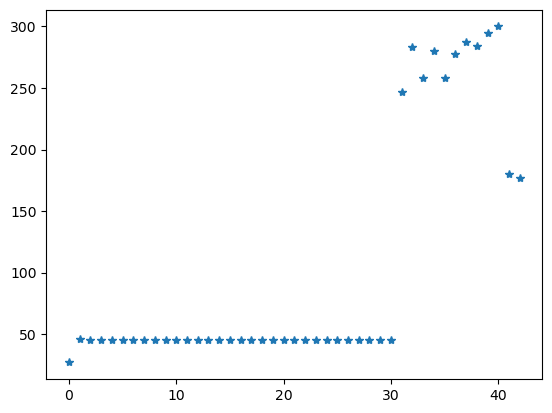

In [1]:
import pandas as pd
import glob
# the input file is created from the Garmin fit file using the following command:
#java -jar FitSDKRelease_21.141.00/java/FitCSVTool.jar  FitDataDir/2024-08-10/16724880599_ACTIVITY.fit 

file_names=glob.glob('../2024-08-10/16*.csv')
import matplotlib.pyplot as plt
import datetime
import numpy as np
import xarray as xr
import cartopy.crs as ccrs


for file_name in file_names:
    garmin_data=pd.read_csv(file_name)
    # select rows with activity Message == record or lap
    garmin_data_1=garmin_data[(garmin_data['Message']=='record') | (garmin_data['Message']=='lap')]


# select columns with the following names ['Message','Field 1', 'Value 1', 'Field 2', 'Value 2', 'Field 3', 'Value 3']
    garmin_data_1=garmin_data_1[['Message','Field 1', 'Value 1', 'Field 2', 'Value 2', 'Field 3', 'Value 3','Field 4','Value 4','Field 5','Value 5','Field 6','Value 6','Field 9','Value 9','Units 9']]


# save the data to a new csv file
    time_stamp=garmin_data_1['Value 1'].iloc[1]
    time_stamp=int(time_stamp)
    cdate=datetime.datetime(1989,12,31)+datetime.timedelta(seconds=time_stamp)
    garmin_data_1.to_csv('garmin_data_%s.csv'%str(cdate),index=False)

# select rows with activity Message ==  lap
    garmin_data_2=garmin_data_1[garmin_data_1['Message']=='lap']
    n_records=garmin_data_2.shape[0]
    timeL=[]
    for i in range(n_records):
        #get time stamp
        time_stamp=garmin_data_2['Value 1'].iloc[i]
        time_stamp=int(time_stamp)
        timeL.append(time_stamp)
    dtL=[]
    for i in range(n_records-1):
        dt=timeL[i+1]-timeL[i]
        dtL.append(dt)

    plt.plot(dtL[1:],'*')
# select rows Field 2==position_lat
    lonL,latL=[],[]
    speedL=[]
    distL=[]
    altL=[]
    cadenceL=[]
    time_stampL=[]
    cadence_unitsL=[]
    for i in range(garmin_data_1.shape[0]):
        if garmin_data_1['Field 2'].iloc[i]=='position_lat' and garmin_data_1['Field 3'].iloc[i]=='position_long':
            lat1=float(garmin_data_1['Value 2'].iloc[i])
            lon1=float(garmin_data_1['Value 3'].iloc[i])
            dist1=float(garmin_data_1['Value 4'].iloc[i])
            speed=float(garmin_data_1['Value 5'].iloc[i])
            time_stamp=int(garmin_data_1['Value 1'].iloc[i])
            cadence=float(garmin_data_1['Value 9'].iloc[i])
            alt=float(garmin_data_1['Value 6'].iloc[i])
            cadence_units=garmin_data_1['Units 9'].iloc[i]
            if abs(lon1)>1 and abs(lat1)>1:
                lonL.append(lon1/2**31*180.)
                latL.append(lat1/2**31*180.)
                distL.append(dist1)
                speedL.append(speed)
                time_stampL.append(time_stamp)
                altL.append(alt)
                cadenceL.append(cadence)
                cadence_unitsL.append(cadence_units)
# create two subplots with ccrs projection

    time_stampL=np.array(time_stampL)-time_stampL[0]
    lonX=xr.DataArray(lonL,dims='time',coords={'time':time_stampL})
    altX=xr.DataArray(altL,dims='time',coords={'time':time_stampL})
    latX=xr.DataArray(latL,dims='time',coords={'time':time_stampL})
    speedX=xr.DataArray(speedL,dims='time',coords={'time':time_stampL})
    distX=xr.DataArray(distL,dims='time',coords={'time':time_stampL})
    cadenceX=xr.DataArray(cadenceL,dims='time',coords={'time':time_stampL})
    cadence_unitsX=xr.DataArray(cadence_unitsL,dims='time',coords={'time':time_stampL})
    data_set=xr.Dataset({'lon':lonX,'lat':latX,'speed':speedX,'dist':distX,'alt':altX,'cadence':cadenceX,'cadence_units':cadence_unitsX})
    compLev=5
    encoding={'lon':{'zlib':True,'complevel':compLev},'lat':{'zlib':True,'complevel':compLev},'speed':{'zlib':True,'complevel':compLev},'dist':{'zlib':True,'complevel':compLev},'alt':{'zlib':True,'complevel':compLev},'cadence':{'zlib':True,'complevel':compLev}}
    data_set.to_netcdf('garmin_data_%s.nc'%str(cdate),encoding=encoding)

xL,yL=[],[]
pointsL=[]
import numpy as np
def dist_lon_lat(lon1,lat1,lon2,lat2):
    import math
    R = 6371.0
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance
calculated_distL=[]
for i in range(1,len(lonL)):
    #plt.plot(lonL[i-1:i+1],latL[i-1:i+1],'r')
    dlon=lonL[i]-lonL[i-1]
    dlat=latL[i]-latL[i-1]
    xL.append([abs(dlon),abs(dlat)])
    yL.append(distL[i]-distL[i-1])
    pointsL.append([lonL[i-1],latL[i-1],lonL[i],latL[i]])
    calculated_distL.append(dist_lon_lat(lonL[i-1],latL[i-1],lonL[i],latL[i]))
xL=np.array(xL)
yL=np.array(yL)
x_mean=np.mean(xL,axis=0)
x_std=np.std(xL,axis=0)
x_scaled=(xL-x_mean)/x_std

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_scaled, yL, test_size=0.33, random_state=42)
nL=len(lonL)
nL2=int(nL/2)-100
X_train, X_test, y_train, y_test = x_scaled[:nL2], x_scaled[nL2:], yL[:nL2], yL[nL2:]
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, y_train)

y_pred=neigh.predict(X_test)
print(neigh.score(X_test,y_test))


-76.84809738770127 -76.81325373239815 39.18131575919688 39.236022513359785


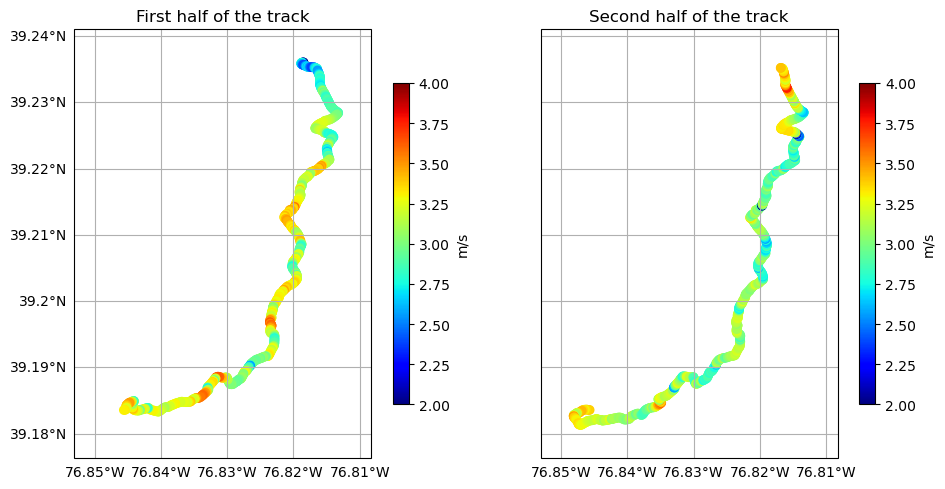

In [21]:

fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(10,5))
#ax = plt.axes(projection=ccrs.PlateCarree())
nL=len(lonL)
nL2=int(nL/2)-10
import numpy as np
img1=ax[0].scatter(lonL[:nL2],latL[:nL2],c=speedL[:nL2],cmap='jet',vmin=2,vmax=4)
gls=ax[0].gridlines(draw_labels=True)
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels
plt.colorbar(img1,label='m/s',shrink=0.75)
ax[0].set_title('First half of the track')
#ax[0].set_extent([np.min(lonL),np.max(lonL),np.min(latL),np.max(latL)])
ax[0].set_extent([-0.005+np.min(lonL),np.max(lonL)+0.005,-0.005+np.min(latL),0.005+np.max(latL)])
img2=ax[1].scatter(lonL[nL2:],latL[nL2:],c=speedL[nL2:],cmap='jet',vmin=2,vmax=4)
plt.colorbar(img2,label='m/s',shrink=0.75)
ax[1].set_title('Second half of the track')
gls=ax[1].gridlines(draw_labels=True)
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels
gls.left_labels=False # suppress left labels
ax[1].set_extent([-0.005+np.min(lonL),np.max(lonL)+0.005,-0.005+np.min(latL),0.005+np.max(latL)])
print(np.min(lonL),np.max(lonL),np.min(latL),np.max(latL))
plt.tight_layout()

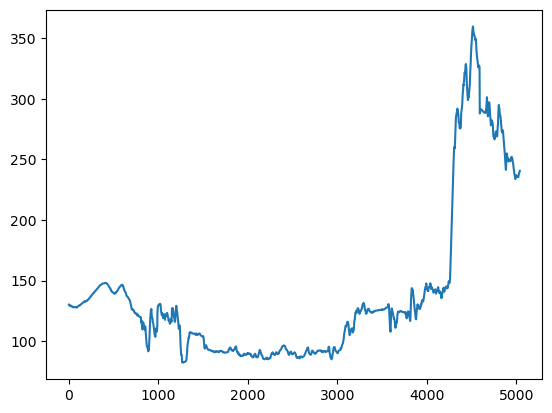

In [26]:
plt.plot(time_stampL,altL)